In [42]:
%load_ext autoreload
%autoreload 2


import numpy as np
import sys

import matplotlib.pyplot as plt  
import seaborn as sns
import figures as figs
import calculations
from types import SimpleNamespace
import pandas as pd

# Ploting jacobians wrt ptilde
from matplotlib.ticker import FormatStrFormatter

import gc  # For garbage collection
import itertools


from seaborn import set_palette
from matplotlib import rc
plt.style.use('seaborn-v0_8-white')
set_palette("colorblind")
rc('font',**{'family':'serif','serif': ['Palatino']})
rc('text',usetex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

# Should make insure text size in latex mode
# plt.rcParams.update({
#     "text.latex.preamble": r"\usepackage{palatino} \normalsize"
# })

from IHANKModel import IHANKModelClass



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
model = IHANKModelClass(name = 'NH')
save_figs = False
shock = calculations.difine_shocks(model, scale=0.3, rho = 0.8)[0]

In [97]:
model.par.tau_ss

0.2

In [101]:
model = IHANKModelClass(name = 'NH')
model.par.beta = 0.99
model.par.tau_ss = 0.21
model.find_ss()
calculations.shares(model)

Non-tradable share: 39.9 goal 40
Energy share: 8.1 goal is 8
Import share of GDP: 30.4 goal is 30
Government share: 17.2 goal is 17
Government dept share: 385.3 goal is 95
MPC: 0.229
anual MPC: 0.646
A/income ratio: 2.381
Consumption home tradable share: 23.4
Consumption forigne tradable share: 28.6


In [103]:
model.par.eta_T_RA

0.7031272105114663

In [95]:
model = IHANKModelClass(name = 'NH')
model.par.beta = 0.99
model.find_ss()
calculations.shares(model)

Non-tradable share: 40.1 goal 40
Energy share: 8.1 goal is 8
Import share of GDP: 30.7 goal is 30
Government share: 16.2 goal is 17
Government dept share: 389.6 goal is 95
MPC: 0.229
anual MPC: 0.646
A/income ratio: 2.381
Consumption home tradable share: 23.3
Consumption forigne tradable share: 28.5


In [87]:
model.par.beta

0.985

In [86]:
model = IHANKModelClass(name = 'NH')
model.par.beta
model.find_ss()
calculations.shares(model)

Non-tradable share: 40.1 goal 40
Energy share: 8.1 goal is 8
Import share of GDP: 30.2 goal is 30
Government share: 17.6 goal is 17
Government dept share: 108.5 goal is 95
MPC: 0.511
anual MPC: 0.943
Consumption home tradable share: 23.3
Consumption forigne tradable share: 28.5


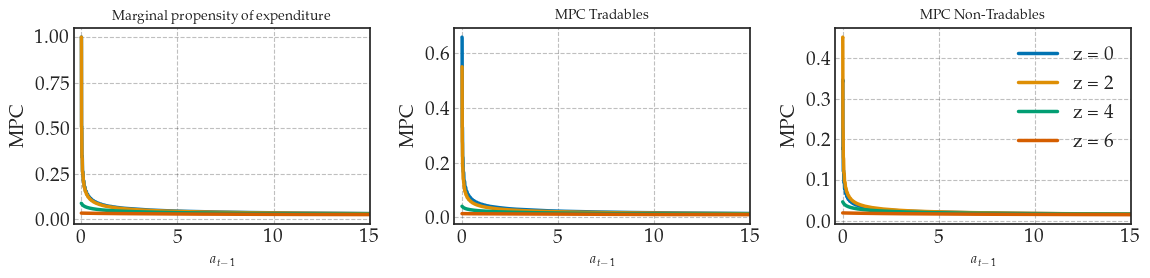

In [66]:
# show_MPC_hh
fig = figs.show_MPC_hh(model)

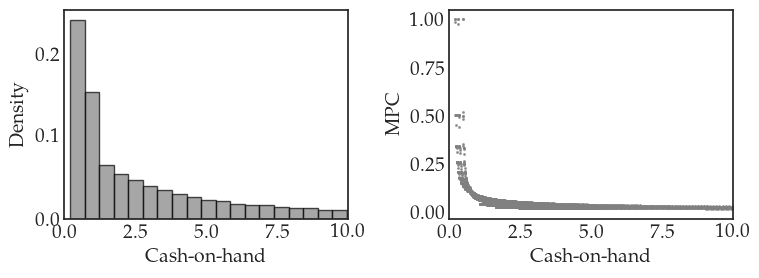

In [93]:
fig = figs.show_coh_and_mpc(model)

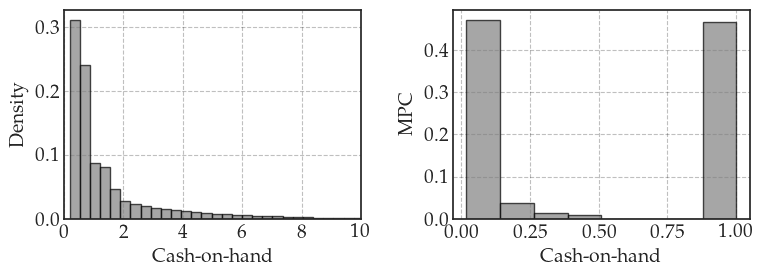

In [64]:

def show_coh_and_mpc(model):
    model.calc_MPCs()

    # Chash on Hand
    coh = model.ss.a[:,:,:] + model.ss.e[:,:,:]
    # Density of 
    D = model.ss.D

    # Flatten arrays
    coh_flat = coh.flatten()
    D_flat = D.flatten()


    ncols = 2
    nrows = 1

    fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)

    ax = fig.add_subplot(121)
    # Plot the histogram with density
    ax.hist(coh_flat, bins=300, weights=D_flat, density=False, edgecolor='k', color='grey', alpha=0.7)
    ax.set_xlabel('Cash-on-hand')
    ax.set_ylabel('Density')
    # ax.set_title('Distribution of Household Cash on Hand')
    ax.set_xlim(0, 10)


    MPC_s = model.ss.MPC_e
    coh = model.ss.a[:,:,:] + model.ss.e[:,:,:]


    # Flatten arrays
    MPC_s_flat = MPC_s.flatten()
    coh_flat = coh.flatten()

    # Create a scatter plot of MPCs against cash on hand

    ax = fig.add_subplot(122)
    ax.hist(MPC_s_flat, bins=8, weights=D_flat, density=False, edgecolor='k', color='grey', alpha=0.7)


    # ax.scatter(coh_flat, MPC_s_flat, s=1, color='grey', alpha=0.5)
    ax.set_xlabel('Cash-on-hand')
    ax.set_ylabel('MPC')

    # ax.set_xlim(0, 10)

    fig.tight_layout()

    return fig
fig = show_coh_and_mpc(model)

In [72]:

def calc_MPCs(self):
    
    ss = self.ss
    par = self.par
    path = self.path
    denom = (1 + par.rF_ss) * (par.a_grid[1:] - par.a_grid[:-1])  # shape (499,)


        # Step 2: List of consumption variables to compute MPC for
    variables = ['e', 'ct', 'cnt']

    # Step 3: Loop over variables and compute MPC with extrapolation
    for var in variables:
        cons = getattr(ss, var)  # e.g., model.ss.e, shape (2, 7, 500)

        # Compute finite differences over assets
        mpc = (cons[:, :, 1:] - cons[:, :, :-1]) / denom  # shape (2, 7, 499)

        # Extrapolate last point using linear extrapolation
        last_diff = mpc[:, :, -1] - mpc[:, :, -2]         # (2, 7)
        mpc_last = mpc[:, :, -1] + last_diff              # (2, 7)

        # Append extrapolated value
        mpc_full = np.concatenate([mpc, mpc_last[:, :, np.newaxis]], axis=2)  # shape (2, 7, 500)

        # Store result back to model.ss
        setattr(ss, f'MPC_{var}', mpc_full) 

calc_MPCs(model)
model.ss.MPC_e.shape

(2, 7, 500)

In [85]:
MPC = np.sum(model.ss.D[:,:,:-1]*(model.ss.e[:,:,1:]-model.ss.e[:,:,:-1])/((1+model.ss.i)*(model.par.a_grid[1:]-model.par.a_grid[:-1])))
print('MPC', MPC)

MPC 0.510991436156096


In [80]:
#MPC's with dimensions (2, 7, 500)
model.ss.MPC_e

# Density of households
model.ss.D


MPC = np.sum(model.ss.D[:,:,:-1]*(model.ss.e[:,:,1:]-model.ss.e[:,:,:-1])/((1+model.ss.i)*(model.par.a_grid[1:]-model.par.a_grid[:-1])))

# mean_MPC = np.sum(model.model.ss.MPC_e * model.model.ss.D[:,:])
# anual_MPC = 1-(1-mean_MPC)**4  # Annualize the MPC

# print(f'mean MPC: {mean_MPC:6.3f}')
# print(f'anual MPC: {anual_MPC:6.3f}')

mean MPC:  0.505
anual MPC:  0.940


In [79]:

def calc_MPC_aggegates(self):
    """ MPC """
    
    par = self.par
    ss = self.ss

    MPC = np.sum(ss.D[:,:,:-1]*(ss.e[:,:,1:]-ss.e[:,:,:-1])/((1+ss.i)*(par.a_grid[1:]-par.a_grid[:-1])))
    iMPC = -self.jac_hh[('E_hh','chi')]
    annual_MPC = np.sum(iMPC[:4,0])
    print(f'{MPC = :.2f}, {iMPC[0,0] = :.2f}')  
    print(f'{annual_MPC = :.2f}')  

calc_MPC_aggegates(model)

KeyError: ('C_hh', 'chi')

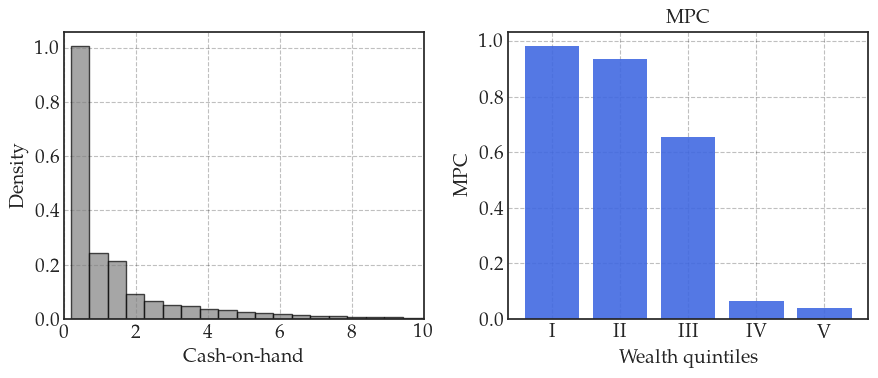

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def show_coh_and_mpc(model):
    model.calc_MPCs()

    # Cash on Hand and density
    coh = model.ss.a + model.ss.e
    D = model.ss.D
    MPC_s = model.ss.MPC_e

    # Flatten arrays
    coh_flat = coh.flatten()
    D_flat = D.flatten()
    MPC_s_flat = MPC_s.flatten()

    # Histogram for COH (unchanged)
    fig = plt.figure(figsize=(9, 4), dpi=100)
    ax1 = fig.add_subplot(121)
    ax1.hist(coh_flat, bins=200, weights=D_flat, density=True, edgecolor='k', color='grey', alpha=0.7)
    ax1.set_xlabel('Cash-on-hand')
    ax1.set_ylabel('Density')
    ax1.set_xlim(0, 10)

    # Compute quintiles based on weighted percentiles
    def weighted_percentile(data, weights, percentiles):
        ix = np.argsort(data)
        sorted_data = data[ix]
        sorted_weights = weights[ix]
        cum_weights = np.cumsum(sorted_weights)
        cum_weights /= cum_weights[-1]
        return np.interp(percentiles, cum_weights, sorted_data)

    quintile_edges = weighted_percentile(coh_flat, D_flat, [0.2, 0.4, 0.6, 0.8])

    # Assign quintile labels
    quintile_labels = np.digitize(coh_flat, quintile_edges, right=True)

    # Compute weighted average MPC per quintile
    mpc_quintile_avg = []
    for i in range(5):
        mask = (quintile_labels == i)
        if np.sum(D_flat[mask]) > 0:
            avg = np.average(MPC_s_flat[mask], weights=D_flat[mask])
        else:
            avg = np.nan
        mpc_quintile_avg.append(avg)

    # Plot MPC by COH quintile
    ax2 = fig.add_subplot(122)
    ax2.bar(['I', 'II', 'III', 'IV', 'V'], mpc_quintile_avg, color='royalblue', alpha=0.9)
    ax2.set_xlabel('Wealth quintiles')
    ax2.set_ylabel('MPC')
    ax2.set_title('MPC', fontsize=14)

    fig.tight_layout()
    return fig

fig = show_coh_and_mpc(model)


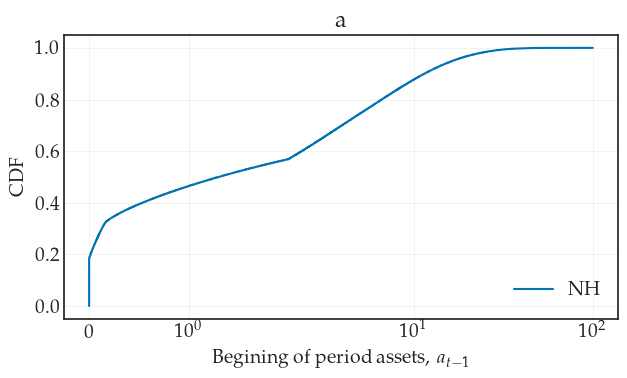

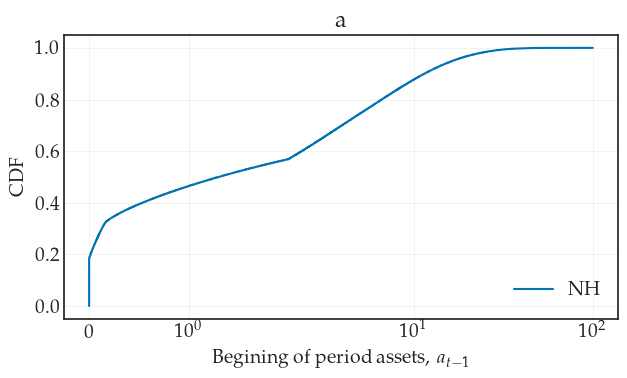

In [94]:
figs.plot_cum([model], ['a'])

In [51]:

def ann_MPCs(self):#, shock_type='income', return_shock=False):
    """ calculate MPCs """

    # a. shock

    

    # 5 percent of labor income
    self.path.UniformT[:,:] = 0.0 
    self.path.UniformT[0,0] = 0.05 * (self.ss.WT * self.ss.NT + self.ss.WNT * self.ss.NNT)
    dI = self.path.UniformT[0,0]    

    # b. solve and simulate    
    self.solve_hh_path()
    self.simulate_hh_path()
    
    # c. calculate MPCs
    MPC = np.zeros(self.par.T)*np.nan

    C_ss = np.sum(self.ss.c*self.ss.D)    
    for t in range(self.par.T):
        MPC[t] = (np.sum(self.path.c[t]*self.path.D[t])-C_ss)/dI
        
    ann_MPC = np.zeros(round(self.par.T/4))

    for j in range(round(self.par.T/4)):
        ann_MPC[j] = np.sum(MPC[j*4:(1+j)*4])  
    
    # d. reset
    self._set_inputs_hh_all_ss()
    

    return ann_MPC, MPC, dI 
    
ann_MPCs(model)

AttributeError: 'types.SimpleNamespace' object has no attribute 'UniformT'

In [50]:
# model.par.tau_ss = 0.
# model.find_ss()
calculations.shares(model)

Non-tradable share: 38.5 goal 40
Energy share: 8.3 goal is 8
Import share of GDP: 27.5 goal is 30
Government share: 26.8 goal is 17
Government dept share: 96.4 goal is 95
Consumption home tradable share: 23.9
Consumption forigne tradable share: 29.3


In [47]:
model.par.tau_ss
model.find_ss()
calculations.shares(model)

Non-tradable share: 38.5
Energy share: 8.3
Import share: 27.5
Import share of GDP: 27.5
Consumption home tradable share: 23.9
Consumption forigne tradable share: 29.3
Government share: 26.8
Government dept share: 96.4


In [26]:
# model.par.nu = 0.585
model.find_ss()
calculations.shares(model)

Non-tradable share: 40.1
Energy share: 6.0
Consumption home tradable share: 37.8
Consumption forigne tradable share: 16.2
Import share of tradables: 37.0
Government share: 17.6
Government dept share: 108.5


Non-tradable share: 43.6
Energy share: 2.8
Consumption home tradable share: 37.5
Consumption forigne tradable share: 16.1
Import share of tradables: 33.5
Government share: 17.6
Government dept share: 108.5


In [4]:
model_CD = IHANKModelClass(name='Cubb-Douglas')
model_CD.par.epsilon = 0.0
model_CD.par.gamma = 0.0
model_CD.find_ss()
model_CD.compute_jacs()
model_CD.find_transition_path(shock, do_end_check=False)

In [6]:
model_NH = IHANKModelClass(name='NH')
model_NH.find_ss()
model_NH.compute_jacs()
model_NH.find_transition_path(shock, do_end_check=False)

In [5]:
model_CD.calc_MPCs()
model_CD.calc_X_P()

In [6]:
np.shape( model_CD.path.q)

(500, 2, 7, 500)

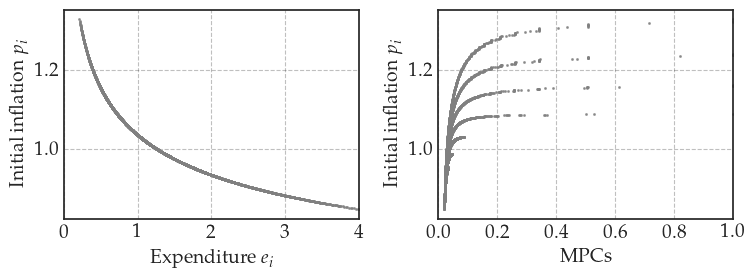

In [38]:

coh = model.ss.a[:,:,:] + model.ss.e[:,:,:]
MPCs = model_CD.ss.MPC_e
q = model_CD.path.q[1,:,:,:]



def show_pi(model):

    model.calc_MPCs()
    model.calc_X_P()

    # Chash on Hand
    coh = model.ss.a[:,:,:] + model.ss.e[:,:,:]
    # Density of 
    D = model.ss.D
    # Prices
    q = (model.path.q[1,:,:,:]-1)*100
    # MPCs
    MPC_s = model.ss.MPC_e

    e = model.ss.e


    # Flatten arrays
    coh_flat = coh.flatten()
    D_flat = D.flatten()
    MPC_s_flat = MPC_s.flatten()
    q_flat = q.flatten()
    e_flat = e.flatten()


    ncols = 2
    nrows = 1

    fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)

    ax = fig.add_subplot(121)
    ax.scatter(e_flat, q_flat, s=1, color='grey', alpha=0.5)
    ax.set_xlabel(r'Expenditure $e_i$')
    ax.set_ylabel(r'Initial inflation $p_i$')

    ax.set_xlim(0, 4)


    ax = fig.add_subplot(122)
    ax.scatter(MPC_s_flat, q_flat, s=1, color='grey', alpha=0.5)
    ax.set_xlabel('MPCs')
    ax.set_ylabel(r'Initial inflation $p_i$')

    ax.set_xlim(0, 1)

    fig.tight_layout()

    return fig

fig = show_coh_and_mpc(model_NH)



In [ ]:


# Flatten arrays
MPC_s_flat = MPCs.flatten()
coh_flat = coh.flatten()
q_flat = q.flatten()

# Create a scatter plot of MPCs against cash on hand
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(122)
ax.scatter(coh_flat, MPC_s_flat, s=1, color='grey', alpha=0.5)
ax.set_xlabel('Cash-on-hand')
ax.set_ylabel('MPC')

ax.set_xlim(0, 10)


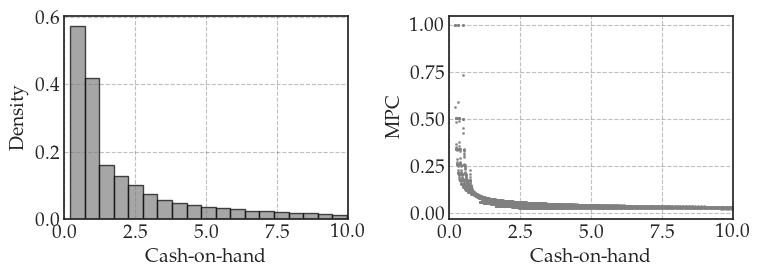

In [4]:


def show_coh_and_mpc(model):
    model.calc_MPCs()

    # Chash on Hand
    coh = model.ss.a[:,:,:] + model.ss.e[:,:,:]
    # Density of 
    D = model.ss.D

    # Flatten arrays
    coh_flat = coh.flatten()
    D_flat = D.flatten()


    ncols = 2
    nrows = 1

    fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)

    ax = fig.add_subplot(121)
    # Plot the histogram with density
    ax.hist(coh_flat, bins=200, weights=D_flat, density=True, edgecolor='k', color='grey', alpha=0.7)
    ax.set_xlabel('Cash-on-hand')
    ax.set_ylabel('Density')
    # ax.set_title('Distribution of Household Cash on Hand')
    ax.set_xlim(0, 10)


    MPC_s = model.ss.MPC_e
    coh = model.ss.a[:,:,:] + model.ss.e[:,:,:]



    # Flatten arrays
    MPC_s_flat = MPC_s.flatten()
    coh_flat = coh.flatten()

    # Create a scatter plot of MPCs against cash on hand

    ax = fig.add_subplot(122)
    ax.scatter(coh_flat, MPC_s_flat, s=1, color='grey', alpha=0.5)
    ax.set_xlabel('Cash-on-hand')
    ax.set_ylabel('MPC')

    ax.set_xlim(0, 10)

    fig.tight_layout()

    return fig

show_coh_and_mpc(model_CD)

In [ ]:
MPC_s = model_CD.ss.MPC_e
coh = model_CD.ss.a[:,:,:] + model_CD.ss.e[:,:,:]

# Flatten arrays
MPC_s_flat = MPC_s.flatten()
coh_flat = coh.flatten()

# Create a scatter plot of MPCs against cash on hand
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.scatter(coh_flat, MPC_s_flat, s=1, color='grey', alpha=0.5)
ax.set_xlabel('Cash-on-hand')
ax.set_ylabel('MPC')

ax.set_xlim(0, 10)

In [ ]:
model_NH = IHANKModelClass(name='Non-homothetic')
# model_NH.find_ss()
# model_NH.compute_jacs()
# model_NH.find_transition_path(shock, do_end_check=False)

In [ ]:
# T_max = 20
model = model
model_alt = None #model_NH


In [ ]:

state_X_CD, state_X_CD_NH, state_CNT_CT_CD_CNT = figs.show_states(model_CD, shock, model_alt=model, T_max=20)

if save_figs:
    state_X_CD.savefig('plots/state_X_CD.png', dpi=300, bbox_inches='tight')
    state_X_CD_NH.savefig('plots/state_X_CD_NH.png', dpi=300, bbox_inches='tight')
    state_CNT_CT_CD_CNT.savefig('plots/state_CNT_CT_CD_CNT.png', dpi=300, bbox_inches='tight')

In [ ]:
state_X_CD.savefig('plots/state_X_CD.png', dpi=300, bbox_inches='tight')
state_X_CD_NH.savefig('plots/state_X_CD_NH.png', dpi=300, bbox_inches='tight')
state_CNT_CT_CD_CNT.savefig('plots/state_CNT_CT_CD_CNT.png', dpi=300, bbox_inches='tight')

# for fig in [state_X_CD, state_X_CD_NH, state_CNT_CT_CD_CNT]: 
#     fig.savefig(f'plots/{fig}.png', dpi=300, bbox_inches='tight')
    

In [ ]:
def IRF_cohort_x(model, shock, model_alt=None, states=None, T_max=20):
    if states is None:
        states = {
            'Poor': [0, 0, 0],
            'Rich': [0, 6, 300]
        }

    # ======= Initialize result dictionaries ========
    CT_diff, CNT_diff, E_hh_diff, Q_diff, X_diff, A_diff = {}, {}, {}, {}, {}, {}
    CT_diff_alt, CNT_diff_alt, E_hh_diff_alt, Q_diff_alt, X_diff_alt, A_diff_alt = {}, {}, {}, {}, {}, {}

    # === Base model ===
    model_base = model.copy(name=model.name)
    model_base.find_ss()
    model_base.compute_jacs()

    model_ns = model_base.copy(name='NoShock')
    model_ns.find_transition_path(shocks=[])

    model_s = model_base.copy(name='Shock')
    model_s.find_transition_path(shocks=shock, do_end_check=False)

    for state in states:
        s0, s1, s2 = states[state]

        Dbeg_choice = np.zeros(model.ini.Dbeg.shape)
        for i in [0, 1]:
            Dbeg_choice[i, s1, s2] = 1.0
        Dbeg_choice /= Dbeg_choice.sum()

        model_ns.simulate_hh_path(Dbeg=Dbeg_choice)
        model_ns.calc_additional_new()

        model_s.simulate_hh_path(Dbeg=Dbeg_choice)
        model_s.calc_additional_new()

        CT_diff[state] = (model_s.path.CT_hh - model_ns.path.CT_hh) / model_ns.path.CT_hh * 100
        CNT_diff[state] = (model_s.path.CNT_hh - model_ns.path.CNT_hh) / model_ns.path.CNT_hh * 100
        E_hh_diff[state] = (model_s.path.E_hh - model_ns.path.E_hh) / model_ns.path.E_hh * 100
        Q_diff[state] = (model_s.path.Q_hh - model_ns.path.Q_hh) / model_ns.path.Q_hh * 100
        X_diff[state] = (model_s.path.X_hh - model_ns.path.X_hh) / model_ns.path.X_hh * 100
        A_diff[state] = (model_s.path.A_hh - model_ns.path.A_hh)  # no percent

    del model_ns, model_s
    gc.collect()

    # === Alternative model ===
    if model_alt is not None:
        model_base_alt = model_alt.copy(name=model_alt.name)
        model_base_alt.find_ss()
        model_base_alt.compute_jacs()

        for state in states:
            s0, s1, s2 = states[state]

            Dbeg_choice = np.zeros(model.ini.Dbeg.shape)
            for i in [0, 1]:
                Dbeg_choice[i, s1, s2] = 1.0
            Dbeg_choice /= Dbeg_choice.sum()

            model_ns_alt = model_base_alt.copy(name='NoShock Homo')
            model_ns_alt.find_transition_path(shocks=[])
            model_ns_alt.simulate_hh_path(Dbeg=Dbeg_choice)
            model_ns_alt.calc_additional_new()

            model_s_alt = model_base_alt.copy(name='Shock Homo')
            model_s_alt.find_transition_path(shocks=shock, do_end_check=False)
            model_s_alt.simulate_hh_path(Dbeg=Dbeg_choice)
            model_s_alt.calc_additional_new()

            CT_diff_alt[state] = (model_s_alt.path.CT_hh - model_ns_alt.path.CT_hh) / model_ns_alt.path.CT_hh * 100
            CNT_diff_alt[state] = (model_s_alt.path.CNT_hh - model_ns_alt.path.CNT_hh) / model_ns_alt.path.CNT_hh * 100
            E_hh_diff_alt[state] = (model_s_alt.path.E_hh - model_ns_alt.path.E_hh) / model_ns_alt.path.E_hh * 100
            Q_diff_alt[state] = (model_s_alt.path.Q_hh - model_ns_alt.path.Q_hh) / model_ns_alt.path.Q_hh * 100
            X_diff_alt[state] = (model_s_alt.path.X_hh - model_ns_alt.path.X_hh) / model_ns_alt.path.X_hh * 100
            A_diff_alt[state] = (model_s_alt.path.A_hh - model_ns_alt.path.A_hh) / model_ns_alt.path.A_hh * 100

        del model_ns_alt, model_s_alt
        gc.collect()

    # === Plotting ===
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    state_colors = {state: next(color_cycle) for state in states}

    # --- Fig 1: Real Expenditure Only ---
    fig_1 = plt.figure(figsize=(4.3 * 2 / 1.1, 3.6 / 1.2), dpi=100)
    ax = fig_1.add_subplot(1, 2, 1)
    for state in states:
        ax.plot(X_diff[state][:T_max], color=state_colors[state], label=state)
    if model_alt is not None:
        for state in states:
            ax.plot(X_diff_alt[state][:T_max], color=state_colors[state], linestyle='--')
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_title(r'Real expenditure ($X$)')
    ax.set_xlabel('Quarters')
    ax.legend()
    ax.set_xticks(np.arange(0, T_max, 4))




    # --- Fig 2: Prices and Real Expenditure ---
    fig_2 = plt.figure(figsize=(4.3 * 2 / 1.1, 3.6 / 1.2), dpi=100)
    ax = fig_2.add_subplot(1, 2, 1)

    ax.plot(Q_diff['Rich'][:T_max], c='black', label='Homothetic', ls='-')

    if model_alt is not None:
        for state in states:
            ax.plot(Q_diff_alt[state][:T_max], color=state_colors[state], ls='--')


    ax.set_ylabel('\% diff. to s.s.')
    ax.set_title(r'Prices ($P$)')
    ax.set_xlabel('Quarters')
    ax.legend()
    ax.set_xticks(np.arange(0, T_max, 4))



    ax = fig_2.add_subplot(1, 2, 2)
    for state in states:
        ax.plot(X_diff[state][:T_max], color=state_colors[state], label=state)
    if model_alt is not None:
        for state in states:
            ax.plot(X_diff_alt[state][:T_max], color=state_colors[state], ls='--')
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_title(r'Real expenditure ($X$)')
    ax.set_xlabel('Quarters')
    ax.legend()
    ax.set_xticks(np.arange(0, T_max, 4))

    fig_2.tight_layout()




    # --- Fig 3: CNT and CT ---
    fig_3 = plt.figure(figsize=(4.3 * 2 / 1.1, 3.6 / 1.2), dpi=100)
    ax = fig_3.add_subplot(1, 2, 1)
    
    for state in states:
        ax.plot(CNT_diff[state][:T_max], color=state_colors[state], label=state)
    if model_alt is not None:
        for state in states:
            ax.plot(CNT_diff_alt[state][:T_max], color=state_colors[state], ls='--')
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_title(r'Non-tradables cons. ($C_{NT}$)')
    ax.set_xlabel('Quarters')
    ax.legend()
    ax.set_xticks(np.arange(0, T_max, 4))

    ax = fig_3.add_subplot(1, 2, 2)
    for state in states:
        ax.plot(CT_diff[state][:T_max], color=state_colors[state], label=state)
    if model_alt is not None:
        for state in states:
            ax.plot(CT_diff_alt[state][:T_max], color=state_colors[state], ls='--')
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_title(r'Tradables cons. ($C_T$)')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0, T_max, 4))

    fig_3.tight_layout()

    return fig_1, fig_2, fig_3




In [ ]:
state_X_CD, state_X_CD_NH, state_CNT_CT_CD_CNT


In [ ]:



def IRF_cohort_x(model,  shock, model_alt= None, states=None, path='X', T_max = 20):
    if states is None:

        # 
        states = {
            'Poor': [0, 0, 0],   # original values
            # 'Middel': [0, 2, 5],   # original values
            'Rich': [0, 6, 300]
        }



    # ======= Initialize result dictionaries  ========
    # Difference to the steady state levels
    CT_diff, CNT_diff, E_hh_diff, Q_diff, X_diff, A_diff = {}, {}, {}, {}, {}, {}
    CT_diff_alt, CNT_diff_alt, E_hh_diff_alt, Q_diff_alt, X_diff_alt, A_diff_alt = {}, {}, {}, {}, {}, {}


    # ======= Computing the differences to steady state ========

    # === Base model ===

    # Initialize the model
    model_base = model.copy(name=model.name)
    model_base.find_ss()
    model_base.compute_jacs()

    # Path of the model without shock
    model_ns = model_base.copy(name='NoShock')
    model_ns.find_transition_path(shocks=[])

    # Path of the model with shock
    model_s = model_base.copy(name='Shock')
    model_s.find_transition_path(shocks=shock, do_end_check=False)


    for state in states:
        s0, s1, s2 = states[state]

        # === Setting the whole distribution to the state
        Dbeg_choice = np.zeros(model.ini.Dbeg.shape)
        for i in [0, 1]:
            Dbeg_choice[i, s1, s2] = 1.0
        Dbeg_choice /= Dbeg_choice.sum()

        # === Base model

        # Simulate the path of D_choice without shock values
        model_ns.simulate_hh_path(Dbeg=Dbeg_choice)
        model_ns.calc_additional_new()

        # Simulate the path of D_choice with shock values
        model_s.simulate_hh_path(Dbeg=Dbeg_choice)
        model_s.calc_additional_new()

        # Save the deviations from the steady state
        CT_diff[state] = (model_s.path.CT_hh - model_ns.path.CT_hh) / model_ns.path.CT_hh * 100
        CNT_diff[state] = (model_s.path.CNT_hh - model_ns.path.CNT_hh) / model_ns.path.CNT_hh * 100
        E_hh_diff[state] = (model_s.path.E_hh - model_ns.path.E_hh) / model_ns.path.E_hh * 100
        Q_diff[state] = (model_s.path.Q_hh - model_ns.path.Q_hh) / model_ns.path.Q_hh * 100
        X_diff[state] = (model_s.path.X_hh - model_ns.path.X_hh) / model_ns.path.X_hh * 100
        A_diff[state] = (model_s.path.A_hh - model_ns.path.A_hh)# / model_ns.path.A_hh * 100


    del model_ns, model_s
    gc.collect()



    # === Alternative model ===
        
    # Compute paths of the alternative model 
        
    if model_alt != None:
        # Initialize the alternative model
        model_base_alt = model_alt.copy(name=model_alt.name)
        model_base_alt.find_ss()
        model_base_alt.compute_jacs()

        # Path of the model without shock
        model_ns_alt = model_base_alt.copy(name='NoShock Alt')
        model_ns_alt.find_transition_path(shocks=[])

        # Path of the model with shock
        model_s_alt = model_base_alt.copy(name='Shock Alt')
        model_s_alt.find_transition_path(shocks=shock, do_end_check=False)

    # Simulate the paths for the alternative model for each state

    if model_alt != None:
        for state in states:
            s0, s1, s2 = states[state]
            
            # === Setting the whole distribution to the state
            Dbeg_choice = np.zeros(model.ini.Dbeg.shape)
            for i in [0, 1]:
                Dbeg_choice[i, s1, s2] = 1.0
            Dbeg_choice /= Dbeg_choice.sum()

            # === Homo model
            model_ns_alt = model_base_alt.copy(name='NoShock Homo')
            model_ns_alt.find_transition_path(shocks=[])
            model_ns_alt.simulate_hh_path(Dbeg=Dbeg_choice)
            model_ns_alt.calc_additional_new()

            model_s_alt = model_base_alt.copy(name='Shock Homo')
            model_s_alt.find_transition_path(shocks=shock, do_end_check=False)
            model_s_alt.simulate_hh_path(Dbeg=Dbeg_choice)
            model_s_alt.calc_additional_new()

            CT_diff_alt[state] = (model_s_alt.path.CT_hh - model_ns_alt.path.CT_hh) / model_ns_alt.path.CT_hh * 100
            CNT_diff_alt[state] = (model_s_alt.path.CNT_hh - model_ns_alt.path.CNT_hh) / model_ns_alt.path.CNT_hh * 100
            E_hh_diff_alt[state] = (model_s_alt.path.E_hh - model_ns_alt.path.E_hh) / model_ns_alt.path.E_hh * 100
            Q_diff_alt[state] = (model_s_alt.path.Q_hh - model_ns_alt.path.Q_hh) / model_ns_alt.path.Q_hh * 100
            X_diff_alt[state] = (model_s_alt.path.X_hh - model_ns_alt.path.X_hh) / model_ns_alt.path.X_hh * 100
            A_diff_alt[state] = (model_s_alt.path.A_hh - model_ns_alt.path.A_hh) / model_ns_alt.path.A_hh * 100


        del model_ns_alt, model_s_alt
        gc.collect()
    



    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    state_colors = {state: next(color_cycle) for state in states}


    if path == 'X':
        ncols = 2
        nrows = 1

        fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)


        ax = fig.add_subplot(nrows, ncols, 1)

        for state in states:
            ax.plot(X_diff[state][:T_max], 
                    color=state_colors[state], label=state)

        if model_alt is not None:
            for state in states:
                ax.plot(X_diff_alt[state][:T_max], 
                        color=state_colors[state], linestyle='--')

        ax.set_ylabel('\% diff. to s.s.')
        ax.set_title(r'Real expenditure ($X$)')
        ax.set_xlabel('Quarters')
        ax.legend()
        ax.set_xticks(np.arange(0,T_max,4))

    if path == 'X_P':
                
        ncols = 2
        nrows = 1

        fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)


        # Prices
        ax = fig.add_subplot(nrows, ncols, 1)

        ax.plot(Q_diff['Rich'][:T_max], c = 'black',
                    label=f'Homothetic', ls ='-')

        if model_alt is not None:
            for state in states:
                ax.plot(Q_diff_alt[state][:T_max], 
                        color=state_colors[state], ls = '--')#, label=state)




        ax.set_ylabel('\% diff. to s.s.')
        ax.set_title(r'Prices ($P$)')
        ax.set_xlabel('Quarters')
        ax.legend()
        ax.set_xticks(np.arange(0,T_max,4))

        fig.tight_layout()



        # Real expenditure
        ax = fig.add_subplot(nrows, ncols, 2)

        for state in states:
            ax.plot(X_diff[state][:T_max], 
                    color=state_colors[state], label=state)

        if model_alt is not None:
            for state in states:
                ax.plot(X_diff_alt[state][:T_max], 
                        color=state_colors[state],  ls ='--' ) #, label=f'{state} {model_alt.name}')


        ax.set_ylabel('\% diff. to s.s.')
        ax.set_title(r'Real expenditure ($X$)')
        ax.set_xlabel('Quarters')
        ax.legend()
        ax.set_xticks(np.arange(0,T_max,4))



    if path == 'CNT_CT':
                
        ncols = 2
        nrows = 1

        fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)


        # Prices
        ax = fig.add_subplot(nrows, ncols, 1)


        for state in states:
            ax.plot(CNT_diff[state][:T_max], 
                    color=state_colors[state], label=state)

        if model_alt is not None:
            for state in states:
                ax.plot(CNT_diff_alt[state][:T_max], 
                        color=state_colors[state],  ls ='--' ) #, label=f'{state} {model_alt.name}')



        ax.set_ylabel('\% diff. to s.s.')
        ax.set_title(r'Non-tradables cons. ($C_{NT}$)')
        ax.set_xlabel('Quarters')
        ax.legend()
        ax.set_xticks(np.arange(0,T_max,4))

        fig.tight_layout()



        # Real expenditure
        ax = fig.add_subplot(nrows, ncols, 2)

        for state in states:
            ax.plot(CT_diff[state][:T_max], 
                    color=state_colors[state], label=state)

        if model_alt is not None:
            for state in states:
                ax.plot(CT_diff_alt[state][:T_max], 
                        color=state_colors[state],  ls ='--' ) #, label=f'{state} {model_alt.name}')


        ax.set_ylabel('\% diff. to s.s.')
        ax.set_title(r'Tradables cons. ($C_T$)')
        ax.set_xlabel('Quarters')
        # ax.legend()
        ax.set_xticks(np.arange(0,T_max,4))

        fig.tight_layout()




    return fig_1, fig_2, fig_3





# Modify this such that the function outputs the three figures that would be created if i called:


# state_X_CD = IRF_cohort_x(model_CD, shock,   path = 'X')
state_X_CD_NH = IRF_cohort_x(model_CD, shock, model_alt= model,  path = 'X_P')
# state_CNT_CT_CD_CNT = IRF_cohort_x(model_CD, shock, model_alt= model,  path = 'CNT_CT')


# state_X_CD, state_X_CD_NH, state_CNT_CT_CD_CNT

In [ ]:
path = 'X_P'
path = 'CT_CNT'

In [ ]:


color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
state_colors = {state: next(color_cycle) for state in states}

ncols = 2
nrows = 1

fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)

# state = 'Poor'
T_max = 20


ax = fig.add_subplot(nrows, ncols, 1)

for state in states:
    ax.plot(X_diff[state][:T_max], 
            color=state_colors[state], label=state)


ax.set_ylabel('\% diff. to s.s.')
ax.set_title(r'Real expenditure ($X$)')
ax.set_xlabel('Quarters')
ax.legend()
ax.set_xticks(np.arange(0,T_max,4))



ax = fig.add_subplot(nrows, ncols, 2)

state = 'Rich'
ax.plot(Q_diff[state][:T_max], 
            color=state_colors[state], label='P')

# for state in states:
#     ax.plot(A_diff[state][:T_max], 
#             color=state_colors[state], label=state)


#Set y axis to 4 decimal places
ax.yaxis.set_major_formatter(FormatStrFormatter('%.6f'))

ax.set_ylabel('\% diff. to s.s.')
ax.set_title(r'P')
ax.set_xlabel('Quarters')
ax.legend()
ax.set_xticks(np.arange(0,T_max,4))

fig.tight_layout()

# if save_figs: fig.savefig('plots/eta_F.png', dpi=300, bbox_inches='tight')
# fig.savefig('plots/state_X_CD.png', dpi=300, bbox_inches='tight')

In [ ]:
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
state_colors = {state: next(color_cycle) for state in states}

ncols = 2
nrows = 1

fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)

state = 'Poor'
T_max = 20


ax = fig.add_subplot(nrows, ncols, 1)

for state in states:
    ax.plot(X_diff[state][:T_max], 
            color=state_colors[state], label=state)

for state in states:
    ax.plot(X_diff_alt[state][:T_max], 
            color=state_colors[state], label=f'{state} NH', ls ='--')


ax.set_ylabel('\% diff. to s.s.')
ax.set_title(r'Real expenditure ($X$)')
ax.set_xlabel('Quarters')
ax.legend()
ax.set_xticks(np.arange(0,T_max,4))



ax = fig.add_subplot(nrows, ncols, 2)


for state in states:
    ax.plot(Q_diff_alt[state][:T_max], 
            color=state_colors[state], label=state)


ax.plot(Q_diff['Rich'][:T_max], c = 'g',
             label=f'Homothetic', ls ='--')


ax.set_ylabel('\% diff. to s.s.')
ax.set_title(r'Prices ($P$)')
ax.set_xlabel('Quarters')
ax.legend()
ax.set_xticks(np.arange(0,T_max,4))

fig.tight_layout()

# if save_figs: fig.savefig('plots/eta_F.png', dpi=300, bbox_inches='tight')
# fig.savefig('plots/state_X_CD.png', dpi=300, bbox_inches='tight')

In [ ]:
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
state_colors = {state: next(color_cycle) for state in states}

ncols = 2
nrows = 1

fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)

state = 'Poor'
T_max = 20


ax = fig.add_subplot(nrows, ncols, 1)

for state in states:
    ax.plot(X_diff[state][:T_max], 
            color=state_colors[state], label=state)


ax.set_ylabel('\% diff. to s.s.')
ax.set_title(r'Real expenditure ($X$)')
ax.set_xlabel('Quarters')
ax.legend()
ax.set_xticks(np.arange(0,T_max,4))



# if save_figs: fig.savefig('plots/eta_F.png', dpi=300, bbox_inches='tight')
# fig.savefig('plots/state_X_CD.png', dpi=300, bbox_inches='tight')

In [ ]:

def plot_panel(ax, title, diff, diff_homo):
    ax.set_title(title)
    for state in states:
        color = state_colors[state]

        ax.plot(diff[state][:T_max], label=f'{state} ', linestyle='-', color=color)

        if model_homo != None:
            ax.plot(diff_homo[state][:T_max], label=f'{state} Alternative', linestyle='--', color=color)
    ax.set_xlabel('Quarters')
    ax.set_ylabel('% diff. to s.s.')


ncols = 2
nrows = 3

fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)


color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
state_colors = {state: next(color_cycle) for state in states}




# ax = fig.add_subplot(nrows, ncols, 1)
# ax.set_title('Real Expenditure (X)')
# for state in states:
#     ax.plot(X_diff[state][:T_max], label=f'{state} ', linestyle='-', color=state_colors[state])

# ax.set_xlabel('Quarters')
# ax.set_ylabel('% diff. to s.s.')
# ax.legend()

# tight layout

# plt.tight_layout()

# if save_figs: fig.savefig('plots/hh_state_CD.png', dpi=300, bbox_inches='tight')

# Plot layout
ax0 = fig.add_subplot(nrows, ncols, 4)
plot_panel(ax0, 'Consumption T', CT_diff, CT_diff_homo)

ax1 = fig.add_subplot(nrows, ncols, 3)
plot_panel(ax1, 'Consumption NT', CNT_diff, CNT_diff_homo)

ax2 = fig.add_subplot(nrows, ncols, 1)
plot_panel(ax2, 'P', Q_diff, Q_diff_homo)

ax3 = fig.add_subplot(nrows, ncols, 2)
plot_panel(ax3, 'X', X_diff, X_diff_homo)



ax3 = fig.add_subplot(nrows, ncols, 5)
plot_panel(ax3, 'E', E_hh_diff, E_hh_diff_homo)

# legened outside box 
ax3.legend()
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [ ]:
model_low_rho = IHANKModelClass(name='Low rho')
model_low_rho.par.rho_i = 0.0
model_low_rho.find_ss()
model_low_rho.compute_jacs()
model_low_rho.find_transition_path(shock, do_end_check=False)


In [ ]:
model_mid_rho = IHANKModelClass(name='mid rho')
model_mid_rho.par.rho_i = 0.3
model_mid_rho.find_ss()
model_mid_rho.compute_jacs()
model_mid_rho.find_transition_path(shock, do_end_check=False)


In [ ]:
model_mid_rho_homo = IHANKModelClass(name='mid rho')
model_mid_rho_homo.par.epsilon = 0.0
model_mid_rho_homo.par.gamma = 0.12
model_mid_rho_homo.par.rho_i = 0.3
model_mid_rho_homo.find_ss()
model_mid_rho_homo.compute_jacs()
model_mid_rho_homo.find_transition_path(shock, do_end_check=False)


In [ ]:
fig = figs.show_IRFs([model_NH, model_mid_rho, model_low_rho])

In [ ]:
model_NH_persistens = IHANKModelClass(name='Non-homothetic persistent r')
model_NH_persistens.par.mon_policy = 'taylor_persistence'
model_NH_persistens.find_ss()
model_NH_persistens.compute_jacs()
model_NH_persistens.find_transition_path(shock, do_end_check=False)


In [ ]:
model_Ho_persistens = IHANKModelClass(name='Homothetic persistent r')
model_Ho_persistens.par.mon_policy = 'taylor_persistence'
model_Ho_persistens.par.epsilon = 0.0
model_Ho_persistens.par.gamma = 0.12
model_Ho_persistens.find_ss()
model_Ho_persistens.compute_jacs()
model_Ho_persistens.find_transition_path(shock, do_end_check=False)


In [ ]:
model_CD_persistens = IHANKModelClass(name='CD persistent r')
model_CD_persistens.par.mon_policy = 'taylor_persistence'
model_CD_persistens.par.epsilon = 0.0
model_CD_persistens.par.gamma = 0.0
model_CD_persistens.find_ss()
model_CD_persistens.compute_jacs()
model_CD_persistens.find_transition_path(shock, do_end_check=False)


In [ ]:
fig = figs.show_IRFs([model_NH_persistens, model_Ho_persistens, model_CD_persistens])

# Stop 

In [ ]:
model_alt = IHANKModelClass(name='Non-homothetic, eta Higher')

model_alt.find_ss()
model_alt.compute_jacs()
model_alt.find_transition_path(shock, do_end_check=False)

In [ ]:
figs.show_IRFs([model_NH,model_alt])

In [ ]:
model_alt_H = IHANKModelClass(name='Non-homothetic, eta Higher')
model_alt_H.par.epsilon = 0.0
model_alt_H.par.gamma = 0.12

model_alt_H.find_ss()
model_alt_H.compute_jacs()
model_alt_H.find_transition_path(shock, do_end_check=False)


In [ ]:
figs.show_IRFs([model_alt,model_alt_H])

In [ ]:
model_H = IHANKModelClass(name='Homothetic')
model_H.par.epsilon = 0.0
model_H.par.gamma =  model_H.par.gamma_homo
model_H.find_ss()
model_H.compute_jacs()
model_H.find_transition_path(shock, do_end_check=False)

In [ ]:
models = [model_NH, model_H]

In [ ]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(1, 1, 1)

for model in models:
    imports_ = ((model.path.CE + model.path.CTF)/(model.path.CTF+ model.path.CE+ model.path.CTH+model.path.CNT) / (model.ss.CE + model.ss.CTF)/(model.ss.CTF+ model.ss.CE+ model.ss.CTH+model.ss.CNT)-1)*100
    ax.plot( imports_[:12], label=model.name)

ax.legend()

In [ ]:
model_NH = model.copy(name='Non-Homothetic Preferences')
# model_NH.par.gamma = model_NH.par.epsilon
# model_NH.par.epsilon = 0.22
# model_NH.par.gamma = 0.45
# model_NH.par.nu  = 0.55
# model_NH.par.alphaE  = 0.18
# model_NH.par.tau_ss  = 0.20
# model_NH.par.alphaF  = 0.3

# model_NH.par.eta_s = 0.5
# model_NH.par.etaF = 0.5
# model_NH.par.etaE = 0.1


# model_NH.par.eta_s = 2.0
# model_NH.par.etaF = 2.0
# model_NH.par.etaE = 0.4

# model_NH.par.mu_p = 1.1
# model_NH.par.mu_w = 1.1
# model_NH.par.sigma_psi = 0.13
model_NH.find_ss()
model_NH.compute_jacs(do_print=False)
model_NH.find_transition_path(shocks=shock, do_end_check=False)



In [ ]:
model_NH.par.eta_T_RA

In [ ]:
# gamma_ = 0.4

# model_.par.gamma = gamma_

gamma_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
eta_list = []

for gamma_ in gamma_list:
    try: 
        model_ = model.copy(name='Test')
        model_.par.epsilon = 0.0
        model_.find_ss()

        
        print(f" gamma={gamma_}, eta =  {model_.par.eta_T_RA}")

        eta_list.append(model_.par.eta_T_RA)

    except Exception as e:
        print(f" gamma={gamma_}, eta X  {e}")
        eta_list.append(np.nan)


In [ ]:
try: 
    model_ = model.copy(name='Test')
    model_.par.epsilon = 0.0
    model_.find_ss()
    model_.compute_jacs(do_print=False)
    model_.find_transition_path(shocks=shock, do_end_check=False)
    figs.show_IRFs([model_])
except Exception as e:
    print(f"Error in model computation: {e}")
    model_ = None

In [ ]:
plt.plot(gamma_list, eta_list, marker='o', linestyle='-')

In [ ]:
def shares(model):
    print(f'Non-tradable share: {model.ss.CNT/(model.ss.CNT+ model.ss.CT)*100:.1f}')
    print(f'Energy share: {model.ss.CE/(model.ss.CNT+ model.ss.CT)*100:.1f}')
    print(f'Consumption home tradable share: {model.ss.CTH/(model.ss.CNT+ model.ss.CT)*100:.1f}')
    print(f'Consumption forigne tradable share: {model.ss.CTF/(model.ss.CNT+ model.ss.CT)*100:.1f}')
    print(f'Import share of tradables: {(model.ss.CE+ model.ss.CTF)/(model.ss.CT)*100:.1f}')
    print(f'Government share: {model.ss.G/(model.ss.GDP)*100:.1f}')



shares(model_NH)

In [ ]:
model_NHCES = model_NH.copy(name = 'Non-homothetic CES')

model_NHCES.par.gamma = model_NHCES.par.epsilon 

model_NHCES.find_ss()
model_NHCES.compute_jacs(do_print=False)
model_NHCES.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
model_CD = model_NH.copy(name = 'Cubb-douglas')

model_CD.par.epsilon = 0.0
model_CD.par.gamma = 0.0

model_CD.find_ss()
model_CD.compute_jacs(do_print=False)
model_CD.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
model_H_etaNH = model_NH.copy(name = 'Cubb-douglas')

model_H_etaNH.par.epsilon = 0.0
print(r'$\gamma$ TBD')
# model_H_etaNH.par.gamma = 
pass 
model_H_etaNH.find_ss()
model_H_etaNH.compute_jacs(do_print=False)
model_H_etaNH.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
models = [model_NH, model_NHCES, model_CD]

for model in models: 
    print(model.name)
    print(f'eta T = {model.par.eta_T_RA}')
    print(f'omega T = {model.par.omega_T}')
    print('\n')

In [ ]:
fig = figs.show_IRFs(models)

In [ ]:
for model in models: 
    print(model.name)
    print(f'eta T = {model.par.eta_T_RA}')
    print(f'omega T = {model.par.omega_T}')
    print('\n')

In [ ]:
model_baseline = model.copy(name='Non-Homothetic Preferences')
# model_baseline.par.gamma = model_baseline.par.epsilon
model_baseline.find_ss()
model_baseline.compute_jacs(do_print=False)
model_baseline.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
model_baseline_h = model.copy(name='Basline Homothetic Preferences')
model_baseline_h.par.epsilon = 0.0
model_baseline_h.par.gamma = 0.18
model_baseline_h.find_ss()
model_baseline_h.compute_jacs(do_print=False)
model_baseline_h.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
fig = figs.show_IRFs([model_baseline, model_baseline_h])

In [ ]:
model_baseline.ss.CNT/(model_baseline.ss.CNT + model_baseline.ss.CT)

In [ ]:
model_baseline.par.nu

In [ ]:
model_low_nu = IHANKModelClass()
model_low_nu.par.nu = 0.475
model_low_nu.find_ss()



In [ ]:
model_low_nu.ss.CNT/(model_low_nu.ss.CNT + model_low_nu.ss.CT)

In [ ]:

def ann_MPCs(self, shock_type='income', return_shock=False):
    """ calculate MPCs """

    # a. shock
    self._set_inputs_hh_all_ss()
    
    if shock_type == 'income':
        # 5 percent of labor income
        self.path.UniformT[:,:] = 0.0 
        self.path.UniformT[0,0] = 0.05 * (self.ss.WT * self.ss.NT + self.ss.WNT * self.ss.NNT)
        dI = self.path.UniformT[0,0]    



    # b. solve and simulate    
    self.solve_hh_path()
    self.simulate_hh_path()
    
    # c. calculate MPCs
    MPC = np.zeros(self.par.T)*np.nan

    C_ss = np.sum(self.ss.c*self.ss.D)    
    for t in range(self.par.T):
        MPC[t] = (np.sum(self.path.c[t]*self.path.D[t])-C_ss)/dI
        
    ann_MPC = np.zeros(round(self.par.T/4))

    for j in range(round(self.par.T/4)):
        ann_MPC[j] = np.sum(MPC[j*4:(1+j)*4])  
    
    # d. reset
    self._set_inputs_hh_all_ss()
    
    if return_shock:
        return ann_MPC, MPC, dI 
    else:
        return ann_MPC, MPC



In [ ]:
# Flexible prices
model_flex = model.copy(name='Flexible Prices')
model_flex.par.kappa_w = 1000.0
model_flex.par.real_wage_motive = 0.0
model_flex.find_ss()
model_flex.compute_jacs(do_print=False)
model_flex.find_transition_path(shocks=shock, do_end_check=False)


In [ ]:
fig = figs.show_IRFs([model_baseline, model_flex])

In [ ]:
model_homothetic = model.copy(name='Homothetic Preferences')
model_homothetic.par.epsilon = 0.0
model_homothetic.par.gamma = 0.18
# model_homothetic.par.gamma = 0.055
model_homothetic.find_ss()
model_homothetic.compute_jacs()
model_homothetic.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
models = [model_baseline, model_homothetic]

# Basics

In [ ]:
fig = figs.plot_policy(model_baseline, ['e', 'cnt', 'ct'])
if save_figs: fig.savefig('plots/policy.png', dpi=300, bbox_inches='tight')


In [ ]:
fig = figs.cum_z_a(model_baseline)
if save_figs: fig.savefig('plots/cum_z_a.png', dpi=300, bbox_inches='tight')


In [ ]:
fig = figs.plot_trans_matrix(model_baseline)
if save_figs: fig.savefig('plots/z_trans.png', dpi=300, bbox_inches='tight')

# Shock 


In [ ]:
fig = figs.plot_PE_s(model_baseline)
if save_figs: fig.savefig('plots/PE_shock.png', dpi=300, bbox_inches='tight')

# Jacobians 

In [ ]:
fig = figs.plot_jac_p(models)
if save_figs: fig.savefig('plots/jac_p.png', dpi=300, bbox_inches='tight')

# IRF's

### All

In [ ]:
paths_ = ['PE', 'P', 'w', 'CE', 'C_hh', 'C_hh','YH', 'X' , 'C_hh']
fig = figs.show_IRFs(models, paths_, T_max=100)
if save_figs: fig.savefig('plots/IRFs_intro.png', dpi=300, bbox_inches='tight')

In [ ]:
paths_ = ['YH', 'P', 'w','X','r_real', 'p' ]
fig = figs.show_IRFs(models, paths_, T_max=100)
if save_figs: fig.savefig('plots/IRFs_main.png', dpi=300, bbox_inches='tight')

In [ ]:
paths_ = ['CT_hh', 'CNT_hh', 'PNT', 'PT']
fig =  figs.show_IRFs([model_baseline, model_homothetic], paths_, maxcol=2, T_max=100)
if save_figs: fig.savefig(f'plots/IRFs_c.png', dpi=300, bbox_inches='tight')

### IRF's prices

In [ ]:
fig =  figs.show_pc_IRFs(model_baseline)
if save_figs: fig.savefig(f'plots/IRFs_pc_all.png', dpi=300, bbox_inches='tight')

In [ ]:
fig =  figs.show_pc_IRFs(model_homothetic)
if save_figs: fig.savefig(f'plots/IRFs_pc_all_homo.png', dpi=300, bbox_inches='tight')

In [ ]:

# fig =  figs.show_pc_IRFs(model_baseline)
# if save_figs: fig.savefig(f'plots/IRFs_pc_all.png', dpi=300, bbox_inches='tight')



# fig =  figs.show_price_IRFs(model_baseline)
# if save_figs: fig.savefig(f'plots/IRFs_p_all.png', dpi=300, bbox_inches='tight')



# fig =  figs.show_c_IRFs(model_baseline)
# if save_figs: fig.savefig(f'plots/IRFs_c_all.png', dpi=300, bbox_inches='tight')

# Importance of epsilon 

In [ ]:
model_e1 = IHANKModelClass(name='epsion = 0.10')
model_e1.par.epsilon = 0.10
# model_e1.par.gamma = 0.24
model_e1.find_ss()
model_e1.compute_jacs()
model_e1.find_transition_path(shocks=shock, do_end_check=False)

model_e05 = IHANKModelClass(name='epsion = 0.05')
model_e05.par.epsilon = 0.05
# model_e05.par.gamma = 0.21
model_e05.find_ss()
model_e05.compute_jacs()
model_e05.find_transition_path(shocks=shock, do_end_check=False)


In [ ]:
model_e00 = IHANKModelClass(name='epsion = 0.00')
model_e00.par.epsilon = 0.00
# model_e00.par.gamma = 0.21
model_e00.find_ss()
model_e00.compute_jacs()
model_e00.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
models = [model_baseline,  model_e1, model_e05 , model_e00]#, model_homothetic]
for model_i in models:
    model_i.calc_additional_new()
    model_i.name = f'cov = {model_i.cov_e_omegaT:.3f}'
    
colors_reds = sns.color_palette("Reds", n_colors=5)
fig = figs.show_IRFs(models, paths=['P', 'X', 'CT', 'CNT' ], colors = colors_reds, maxcol=2)
# if save_figs: fig.savefig('plots/IRFs_epsion.png', dpi=300, bbox_inches='tight')

In [ ]:


def show_IRFs(models, colors):

    ncols = 2
    nrows = 2
    T_max = 17
    linewidth= 1.0

    fig = plt.figure(figsize=(4.3*ncols/1.1,3.6*nrows/1.2),dpi=100)
    # Tradable and  non-tradable
    # fig.suptitle(f'{model[0].name}, Consumption Response', fontsize=20)
    
    ax = fig.add_subplot(nrows,ncols,1)   
    for i, model in enumerate(models): 
    # ax.plot((model.path.p-model.ss.p),label='$p$', linewidth=linewidth)
        ax.plot(((model.path.P-model.ss.P)/model.ss.P-1)*100,label='$C_T$', linewidth=linewidth, color= colors[i])
        # ax.plot(((model.path.CNT-model.ss.CNT)/model.ss.CNT),ls='--',label='$C_{NT}$', linewidth=linewidth)
    # ax.plot((model.path.PNT-model.ss.PNT),ls=':',label='$P_{NT}$', linewidth=linewidth)
    ax.set_xlim([0,T_max])
    ax.set_ylabel('\% diff. to s.s.')
    # ax.legend()
    ax.set_title('CPI (P)')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0,T_max,4))

    # Energy and non energy tradable 
    ax = fig.add_subplot(nrows,ncols,2)    
    for model in models: 
        ax.plot(((model.path.X-model.ss.X)/model.ss.X-1),label='$C_E$', linewidth=linewidth, color= colors[i])
        # ax.plot(((model.path.CTHF-model.ss.CTHF)/model.ss.CTHF),ls='--',label='$C_{goods}$', linewidth=linewidth)
    # ax.plot((model.path.PE-model.ss.PE),ls=':',label='$P_{Energy}$', linewidth=linewidth)
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_xlim([0,T_max])
    # ax.legend()
    ax.set_title('Real Expenditure')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0,T_max,4))
    
    ax = fig.add_subplot(nrows,ncols,3)   
    for i, model in enumerate(models): 
    # ax.plot((model.path.p-model.ss.p),label='$p$', linewidth=linewidth)
        ax.plot(((model.path.CT-model.ss.CT)/model.ss.CT-1),label='$C_T$', linewidth=linewidth, color= colors[i])
        # ax.plot(((model.path.CNT-model.ss.CNT)/model.ss.CNT),ls='--',label='$C_{NT}$', linewidth=linewidth)
    # ax.plot((model.path.PNT-model.ss.PNT),ls=':',label='$P_{NT}$', linewidth=linewidth)
    ax.set_xlim([0,T_max])
    ax.set_ylabel('\% diff. to s.s.')
    # ax.legend()
    ax.set_title('Cons. Tradable goods')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0,T_max,4))

    # Energy and non energy tradable 
    ax = fig.add_subplot(nrows,ncols,4)    
    for model in models: 
        ax.plot(((model.path.CNT-model.ss.CNT)/model.ss.CNT-1)*100,label='$C_E$', linewidth=linewidth, color= colors[i])
        # ax.plot(((model.path.CTHF-model.ss.CTHF)/model.ss.CTHF),ls='--',label='$C_{goods}$', linewidth=linewidth)
    # ax.plot((model.path.PE-model.ss.PE),ls=':',label='$P_{Energy}$', linewidth=linewidth)
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_xlim([0,T_max])
    # ax.legend()
    ax.set_title('Cons. Non-tradable services')
    ax.set_xlabel('Quarters')
    ax.set_xticks(np.arange(0,T_max,4))


    fig.tight_layout()

    return fig

colors_reds = sns.color_palette("Reds", n_colors=4)
models = [model_baseline, model_homothetic]
fig = show_IRFs(models, colors_reds)


# Importance of gamma

In [ ]:
model_g29 = model_baseline.copy()


In [ ]:
model_g40 = IHANKModelClass(name='gamma = 0.40')
model_g40.par.gamma = 0.40
model_g40.find_ss()
model_g40.compute_jacs()
model_g40.find_transition_path(shocks=shock, do_end_check=False)


In [ ]:
model_g20 = IHANKModelClass(name='gamma = 0.20')
model_g20.par.gamma = 0.20
model_g20.find_ss()
model_g20.compute_jacs()
model_g20.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
models = [model_g20, model_baseline,  model_g40]
for model_i in models:
    model_i.calc_additional_new()
    model_i.name = f'eta = {model_i.par.eta_T_RA:.3f}'
    
colors_reds = sns.color_palette("Reds", n_colors=3)
path_eta = ['CT', 'CNT', 'YH', 'X'] 
fig = figs.show_IRFs(models, path_eta, colors = colors_reds, maxcol=2)
if save_figs: fig.savefig('plots/IRFs_gamma.png', dpi=300, bbox_inches='tight')

# Effect of real wage stabilisation motive 

### Results 

In [ ]:
model_no_ws = IHANKModelClass(name='$\zeta = 0$')
model_no_ws.par.real_wage_motive = 0.0
model_no_ws.find_ss()
model_no_ws.compute_jacs()
model_no_ws.find_transition_path(shocks=shock, do_end_check=False)


In [ ]:
paths_wage_stabilisation = ['W', 'P', 'w']
model_baseline.name = '$\zeta = 5.0$'
fig = figs.show_IRFs([model_baseline, model_no_ws], paths_wage_stabilisation, maxcol=3)
if save_figs: fig.savefig('plots/IRFs_wp_spiral.png', dpi=300, bbox_inches='tight')

### IRFs robustness

In [ ]:
model_no_ws_homo = IHANKModelClass(name='$\zeta = 0 Homo$')
model_no_ws_homo.par.real_wage_motive = 0.0
model_no_ws_homo.par.epsilon = 0.0
model_no_ws_homo.par.gamma = 0.18
model_no_ws_homo.find_ss()
model_no_ws_homo.compute_jacs()
model_no_ws_homo.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
model_no_ws.name = '$\zeta = 0$ Non-homothetic'
model_no_ws_homo.name = '$\zeta = 0$ Homothetic'
fig = figs.show_IRFs([ model_no_ws, model_no_ws_homo], maxcol=3)
if save_figs: fig.savefig('plots/IRFs_real_wage_motive.png', dpi=300, bbox_inches='tight')

# Consumption

### Goods and services

# Correlations

In [ ]:
# model_baseline.calc_additional_new()
fig = figs.plot_cor_e(model_baseline)
if save_figs: fig.savefig('plots/cor_e.png', dpi=300, bbox_inches='tight')

# Forigne economy 

In [ ]:

paths_forigne = ['i', 'r_real', 'E', 'Q', 'PTH', 'CTH_s' ]
fig = figs.show_IRFs(models, paths_forigne)
if save_figs: fig.savefig('plots/IRFs_forigne.png', dpi=300, bbox_inches='tight')

# No wage stabilisation motive

# Other elasticities of substitution

### Eta E

In [ ]:
model_etaE05 = IHANKModelClass(name= '$\eta_E = 0.5$')
model_etaE05.par.etaE = 0.5
model_etaE05.find_ss()
model_etaE05.compute_jacs()
model_etaE05.find_transition_path(shock, do_end_check=False)

In [ ]:
model_etaE2 = IHANKModelClass(name= '$\eta_E = 2$')
model_etaE2.par.etaE = 2.0
model_etaE2.find_ss()
model_etaE2.compute_jacs()
model_etaE2.find_transition_path(shock, do_end_check=False)


In [ ]:
model_etaE5 = IHANKModelClass(name= '$\eta_E = 5$')
model_etaE5.par.etaE = 5.0
model_etaE5.find_ss()
model_etaE5.compute_jacs()
model_etaE5.find_transition_path(shock, do_end_check=False)


In [ ]:
model_baseline.name = '$\eta_E =0.0$'
models = [model_baseline, model_etaE05 , model_etaE2, model_etaE5]
paths_ = ['CE','YH', 'X']
fig = figs.show_IRFs(models, paths_)
if save_figs: fig.savefig('plots/eta_E.png', dpi=300, bbox_inches='tight')

### Eta F and eta S 

In [ ]:
model_etaF1 = IHANKModelClass(name= 'Eta = 1.0')
model_etaF1.par.etaF = 1.0
model_etaF1.par.eta_s = 1.0
model_etaF1.find_ss()
model_etaF1.compute_jacs()
model_etaF1.find_transition_path(shock, do_end_check=False)

In [ ]:
model_etaF2 = IHANKModelClass(name= 'Eta = 2.0')
model_etaF2.par.etaF = 2.0
model_etaF2.par.eta_s = 2.0
model_etaF2.find_ss()
model_etaF2.compute_jacs()
model_etaF2.find_transition_path(shock, do_end_check=False)

In [ ]:
model_etaF5 = IHANKModelClass(name= 'Eta = 3.0')
model_etaF5.par.etaF = 3.0
model_etaF5.par.eta_s = 3.0
model_etaF5.find_ss()
model_etaF5.compute_jacs()
model_etaF5.find_transition_path(shock, do_end_check=False)

In [ ]:
model_baseline.name = 'Eta = 0.5'
models = [model_baseline, model_etaF1 , model_etaF2, model_etaF5]

paths_ = ['PTH', 'E', 'PTH_s', 'CTH', 'CTF', 'CTH_s' , 'X', 'PF']
# paths_ = [ 'CTH', 'CTF', 'CTH_s' , 'X']
fig = figs.show_IRFs(models, paths_)
# if save_figs: fig.savefig('plots/eta_F.png', dpi=300, bbox_inches='tight')

# Energy share

In [ ]:
# High energy 
model_EHigh = IHANKModelClass(name = 'High Energy')
model_EHigh.par.alphaE = model_baseline.par.alphaE *2
model_EHigh.find_ss()
model_EHigh.compute_jacs()
model_EHigh.find_transition_path(shock, do_end_check=False)


# High energy 
model_ELow = IHANKModelClass(name = 'Low Energy')
model_ELow.par.alphaE = model_baseline.par.alphaE /2
model_ELow.find_ss()
model_ELow.compute_jacs()
model_ELow.find_transition_path(shock, do_end_check=False)

In [ ]:
paths = []
fig = figs.show_IRFs([model_ELow,model_baseline, model_EHigh])
if save_figs: fig.savefig('plots/eta_F.png', dpi=300, bbox_inches='tight')

# Monetary Policy

In [ ]:
model_tight = IHANKModelClass(name='Tight mon policy')
model_tight.par.phi = 2.0
model_tight.find_ss()
model_tight.compute_jacs()
model_tight.find_transition_path(shocks=shock, do_end_check=False)

In [ ]:
# In notbook_complete2 copy
# hh_state_basline 
fig = figs.show_IRFs([model_baseline, model_tight])